In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

In [2]:
# Defining a global random number generator
RNG = np.random.default_rng()

# Complex Multinomial Processing Tree (MPT) Model for Aphasia

In this notebook, we extend the simplified MPT model for aphasia that was implemented in class to the full model depicted in [(Walker et al., 2018)](https://psycnet.apa.org/doiLanding?doi=10.1037%2Fpas0000529). We develop the forward model as a simulator, and estimated the aphasia catagories using `Stan`.

### Parameters and Model

The model is depicted in the following figure:

<img src="./assets/aphasia.png" width=80% height=80% />

The table below lists the 8 types of responses (categories):

| Response (Category) | Description | Example | 
| --- | --- | --- |
| Correct (C) | The response matches the target image. | cat |
| Semantic (S) | The response is a word with only a semantic relation to the target | dog |
| Formal (F) | The response is a word with only a phonological relation to the target image. | hat |
| Mixed (M) | The response is a word with both a semantic and phonological relation the target image. | rat |
| Unrelated (U) | The response is a word with neither a semantic nor a phonological relation to the target. | fog |
| Neologism (N) | The response is not a word, but it has a phonological relation to the target image. | cag |
| Abstruse Neologism (AN) | The response is not a word, nor does it have a phonological relation to the target. | rog |
| Other (NR) | All other responses, including omissions, descriptions, non-nouns, etc. | - |

The table below lists the 8 latent parameters and corresponding interpretations:

| Parameter | Description | 
| --- | --- |
| $a$ | Probability of initiating an attempt |
| $b$ | Probability of identifying the correct semantic neighborhood of the picture |
| $c$ | Probability of retrieving correct lexical-semantic information |
| $d$ | Probability of retrieving correct lexical-phonological information |
| $e$ | Probability of selecting a target lexeme over competitors |
| $f$ | Probability of retrieving correct phonemes |
| $g$ | Probability of selecting a target word from a pool of candidates |
| $h$ | Probability of a phoneme change in a random word creating a real word |

Based upon the graphical model shown in the figure, the MPT model can be mathematically formulated as

\begin{align}
    \mathrm{NR} &= 1-a, \\
    \mathrm{AN} &= a(1-bc)(1-f)(1-h), \\
    \mathrm{U} &= a[(1-b)f + (1-bc)(1-f)h], \\
    \mathrm{S} &= ab(1-c)f, \\
    \mathrm{F} &= abc(1-f)(1-g), \\
    \mathrm{N} &= abc(f-df+g-fg), \\
    \mathrm{M} &= abcd(1-e)f, \\
    \mathrm{C} &= abcdef.
\end{align}

## Simulator

Based upon the model, we can create a function for the forward simulation of the trials, as below:

In [30]:
# Define the simulator
def aphasia_simulator(theta, num_trials=120, rng=None):

    """ 
    Simulates the full MPT models for aphasia patients over repeated trials.

    Parameters
    ----------
    theta           : numpy.array of shape (8,)
        Latent parameters for the response categories: a, b, c, d, e, f, g, h.
    num_trials      : int
        Number of trials to be repeated
    rng             : numpy.random.rng
        A random number generator. If none defined, default is used.

    Returns
    -------
    true_probs      : dict
        Dictionary of true probabilities for all response categories
    true_samples    : numpy.array of shape (8,)
        Simulated sampled responses for all response categories
    """

    if rng is None:
        rng = np.random.default_rng()


    a, b, c, d, e, f, g, h = theta

    true_probs = {
        "other": 1 - a,
        "abstruse": a * (1 - f) * (1 - h) * (1 - b * c),
        "unrelated": a * (1 - b) * f + a * (1 - b * c) * (1 - f) * h,
        "semantic": a * b * (1 - c) * f,
        "formal": a * b * c * (1 - f) * (1 - g),
        "neologism": a * b * c * (f - d * f + g - f * g),
        "mixed": a * b * c * d * (1 - e) * f,
        "correct": a * b * c * d * e * f
    }

    true_samples = rng.multinomial(n=num_trials, pvals=list(true_probs.values()))
    return true_probs, true_samples

We need to verify that the sum of all categorical parameters is 1. In addition, we need to make sure that the sum of all categories is the fixed number of trials previously defined.

In [25]:
# Ground truth parameters
a = 0.44
b = 0.58
c = 0.2
d = 0.69
e = 0.73
f = 0.86
g = 0.57
h = 0.36

# Packing the parameters together
theta = np.array([a, b, c, d, e, f, g, h])

# Number of trials
n_trials = 240
true_probs, true = aphasia_simulator(theta, n_trials, RNG)
sum(true_probs.values())

1.0000000000000002

In [22]:
full_mpt_code = """
data {
  int<lower=1> N; // Number of trials
  int<lower=1> K; // Number of categories
  array[K] int<lower=0, upper=N> freqs;
}

parameters {
  real<lower=0, upper=1> a;
  real<lower=0, upper=1> b;
  real<lower=0, upper=1> c;
  real<lower=0, upper=1> d;
  real<lower=0, upper=1> e;
  real<lower=0, upper=1> f;
  real<lower=0, upper=1> g;
  real<lower=0, upper=1> h;
}

transformed parameters {
  simplex[K] theta;
  theta[1] = 1 - a;
  theta[2] = a * (1 - f) * (1 - h) * (1 - b * c);
  theta[3] = a * (1 - b) * f + a * (1 - b * c) * (1 - f) * h;
  theta[4] = a * b * (1 - c) * f;
  theta[5] = a * b * c * (1 - f) * (1 - g);
  theta[6] = a * b * c * (f - d * f + g - f * g);
  theta[7] = a * b * c * d * (1 - e) * f;
  theta[8] = a * b * c * d * e * f;
}

model {
  a ~ beta(2, 2);
  b ~ beta(2, 2);
  c ~ beta(2, 2);
  d ~ beta(2, 2);
  e ~ beta(2, 2);
  f ~ beta(2, 2);
  g ~ beta(2, 2);
  h ~ beta(2, 2);

  target += dirichlet_lpdf(theta | rep_vector(1, K));
  target += multinomial_lpmf(freqs | theta);
}

generated quantities {
  // Predictions of frequencies go here
  array[K] int preds = multinomial_rng(theta, N);
}
"""

In [26]:
mpt_dict = {
    'freqs': data,
    'N': n_trials,
    'K': data.shape[0]
}

full_mpt_posterior = stan.build(program_code=full_mpt_code, data=mpt_dict)

Building...



Building: 41.1s, done.

In [27]:
fit = full_mpt_posterior.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Sampling:   0%
Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!


### Parameter recovery and predictions

In [28]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.443,0.032,0.383,0.503,0.000,0.000,13139.0,7605.0,1.0
b,0.527,0.073,0.405,0.674,0.001,0.001,6253.0,4264.0,1.0
c,0.270,0.062,0.155,0.388,0.001,0.000,9003.0,7126.0,1.0
d,0.705,0.126,0.464,0.928,0.001,0.001,10490.0,5566.0,1.0
e,0.692,0.124,0.465,0.910,0.001,0.001,12827.0,6938.0,1.0
f,0.790,0.090,0.620,0.935,0.001,0.001,4920.0,4940.0,1.0
g,0.510,0.205,0.131,0.864,0.002,0.001,10495.0,5194.0,1.0
h,0.555,0.181,0.227,0.871,0.002,0.002,5311.0,6566.0,1.0
theta[0],0.557,0.032,0.497,0.617,0.000,0.000,13139.0,7605.0,1.0
theta[1],0.031,0.011,0.013,0.051,0.000,0.000,12691.0,7608.0,1.0


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'c'}>, <Axes: title={'center': 'c'}>],
       [<Axes: title={'center': 'd'}>, <Axes: title={'center': 'd'}>],
       [<Axes: title={'center': 'e'}>, <Axes: title={'center': 'e'}>],
       [<Axes: title={'center': 'f'}>, <Axes: title={'center': 'f'}>],
       [<Axes: title={'center': 'g'}>, <Axes: title={'center': 'g'}>],
       [<Axes: title={'center': 'h'}>, <Axes: title={'center': 'h'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'preds'}>,
        <Axes: title={'center': 'preds'}>]], dtype=object)

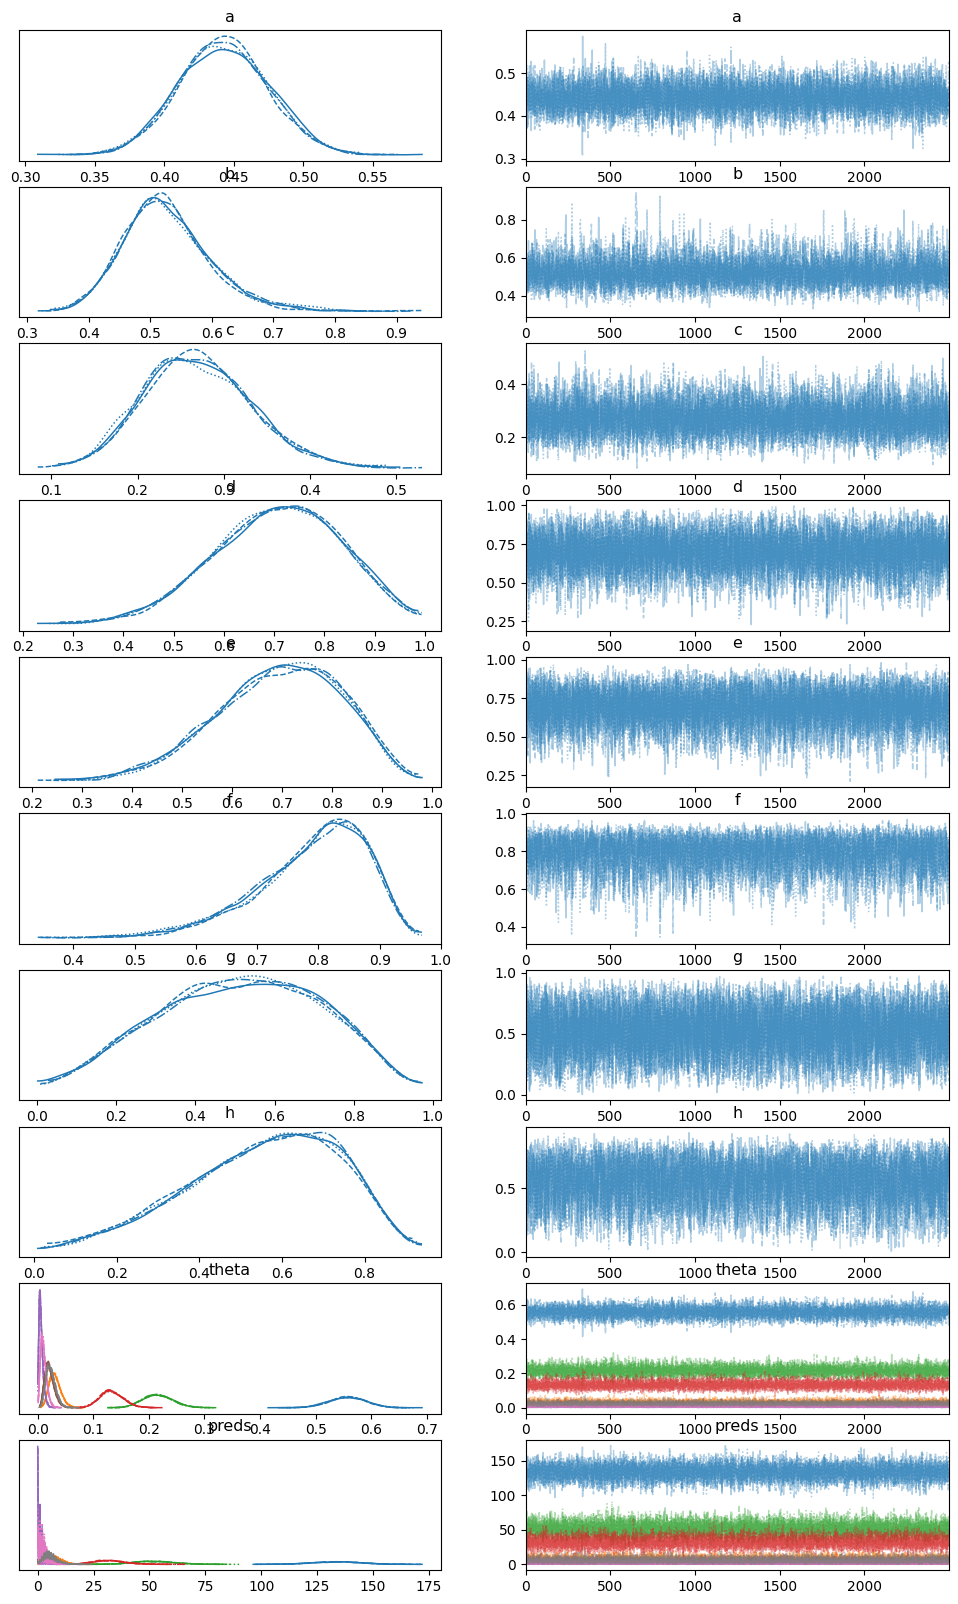

In [29]:
# Convergence
az.plot_trace(fit)
